/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Baseline TP%=66.67, TN%=93.33


/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691:

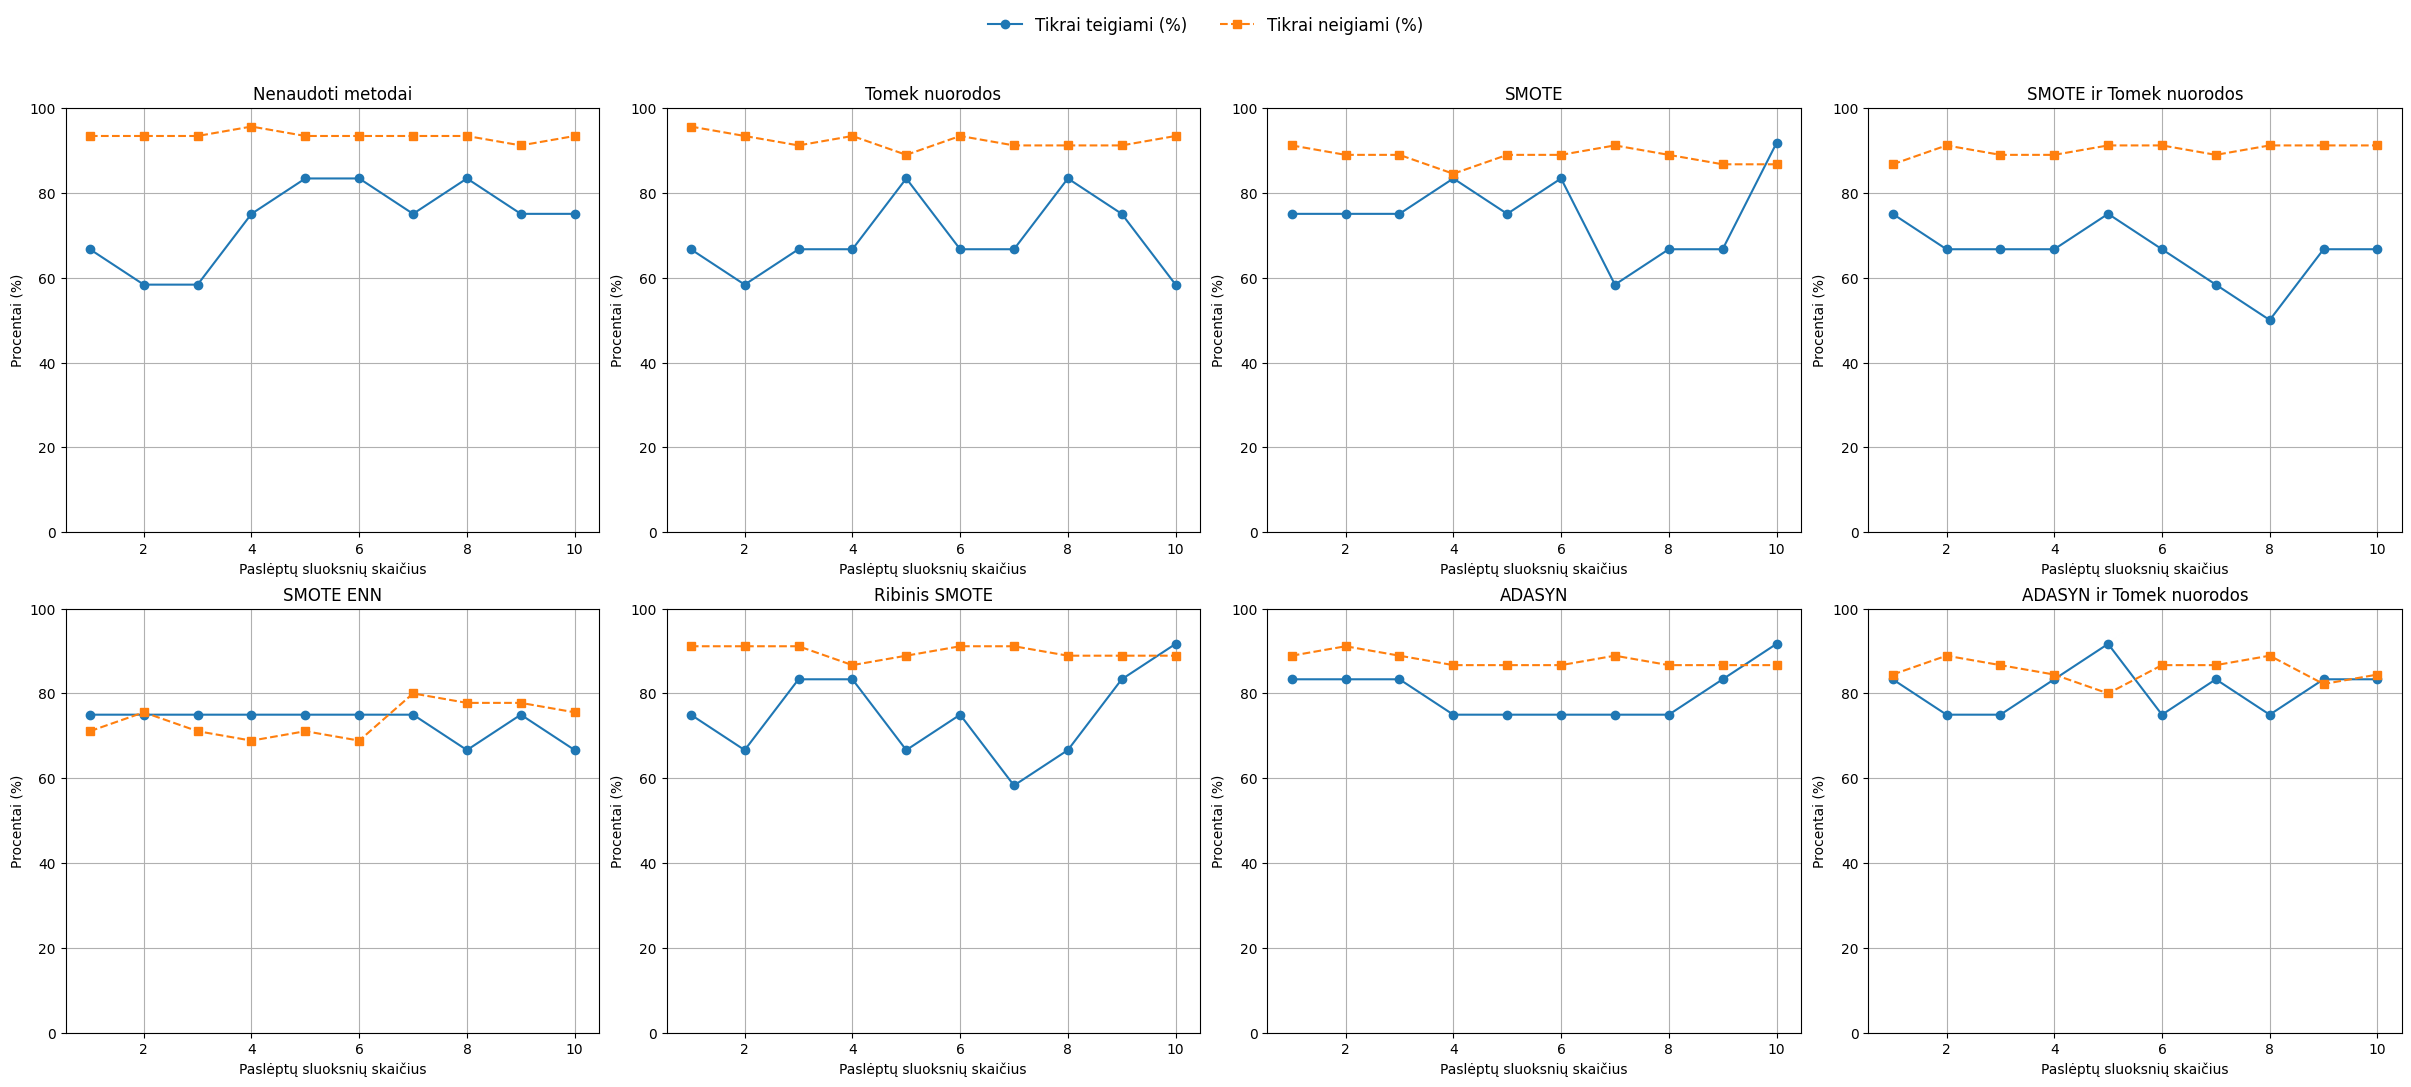

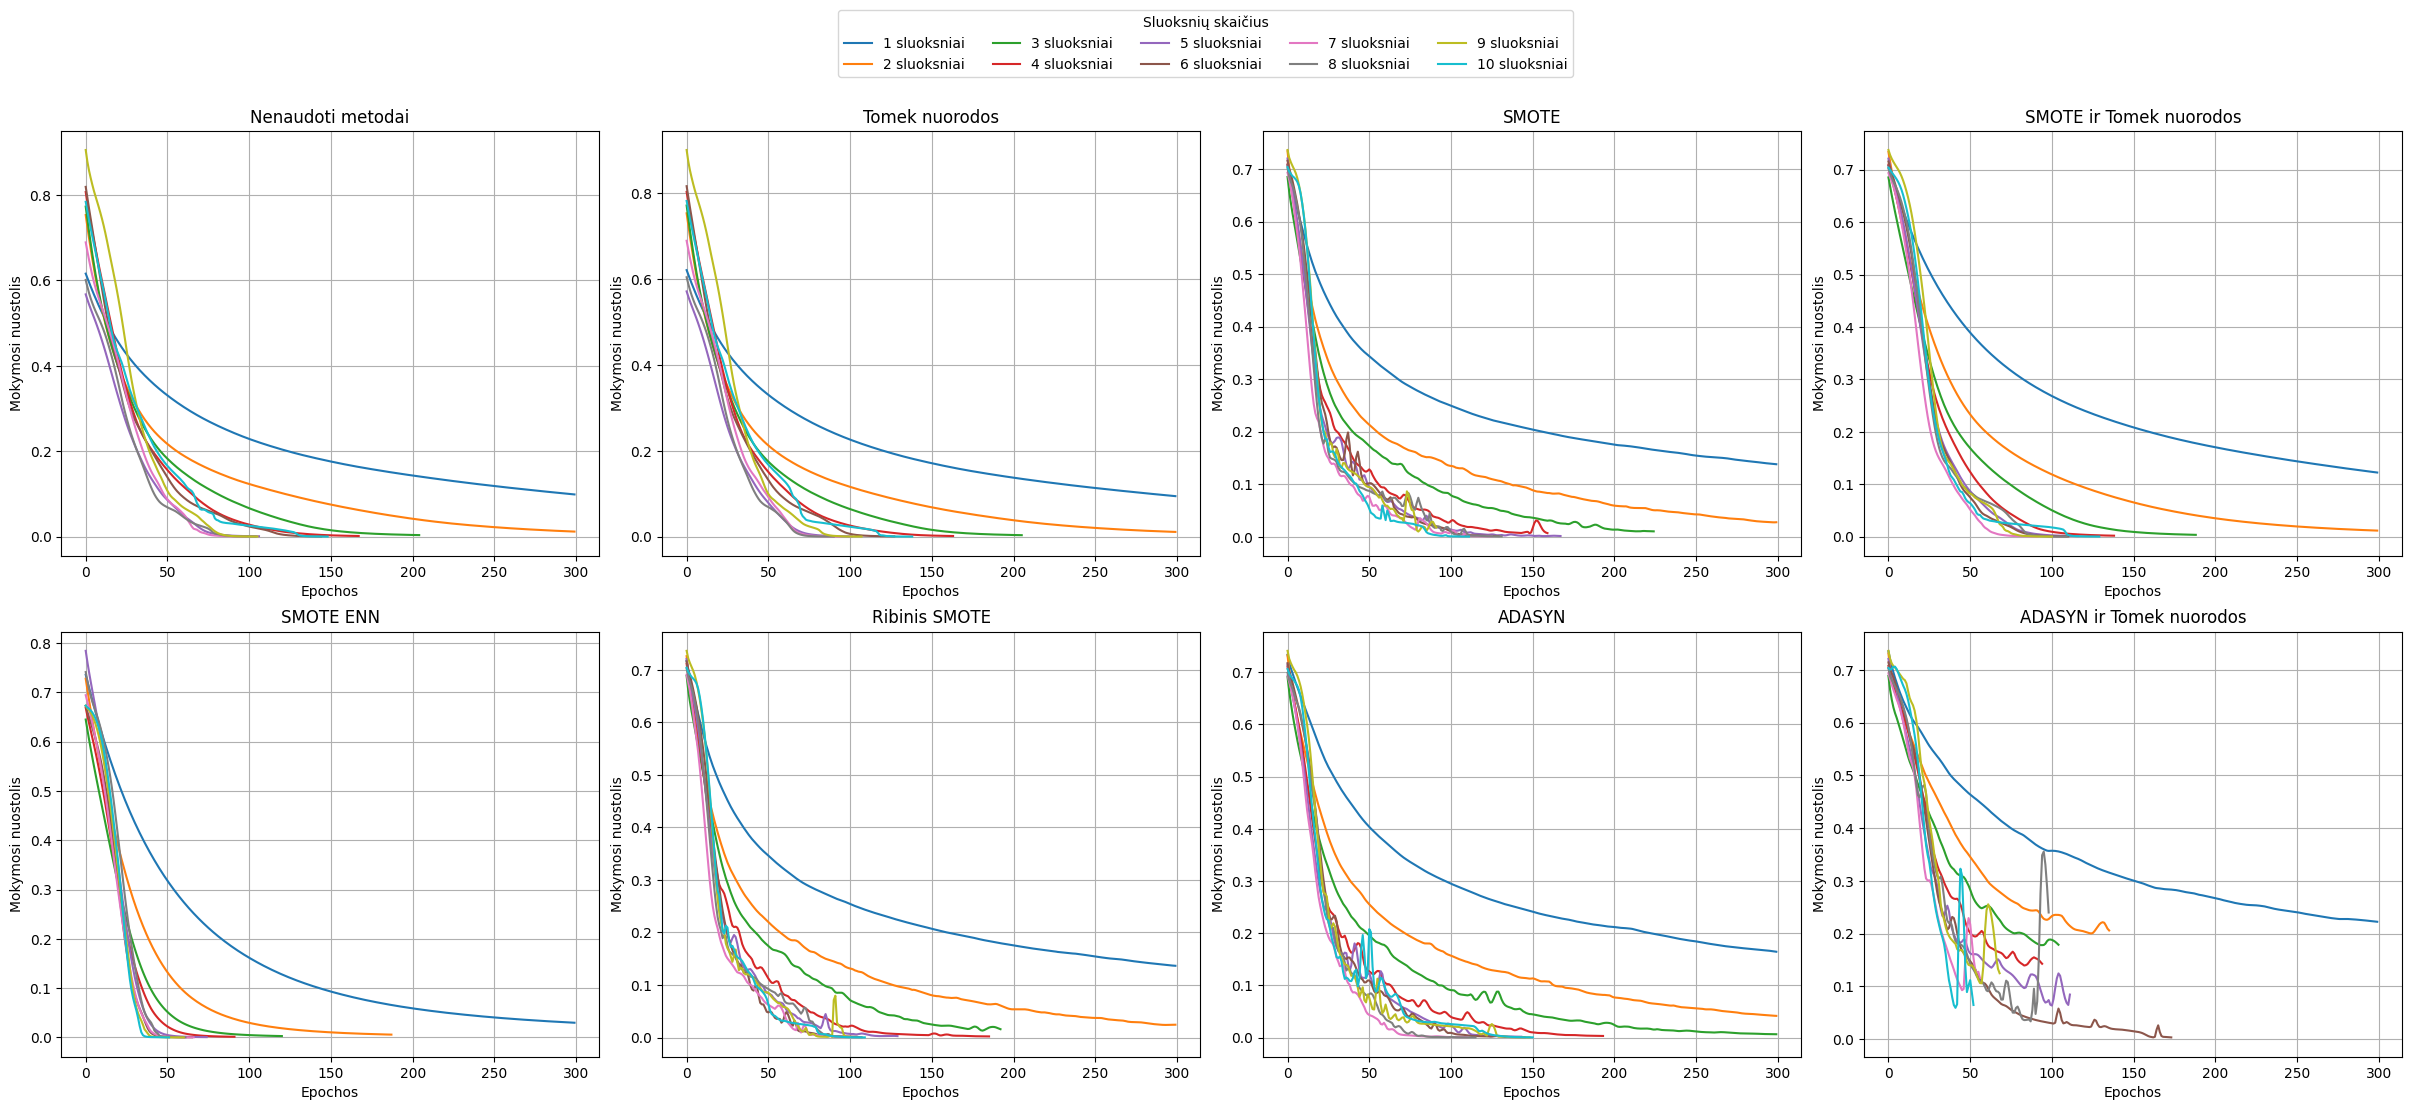

In [10]:
# MLP klasifikavimo rezultatai keičiant paslėptų sluoksnių skaičių
# Mokymosi nuostolių analizė pagal MLP gylį naudojant po 50 neuronų sluoksnyje
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

df = pd.read_csv('dataset_heart_reduced.csv', encoding='utf-8-sig')
X = df.drop(columns=['Širdies liga'])
y = df['Širdies liga']

Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=900
)

scaler0  = StandardScaler().fit(Xb_tr)
Xb_tr_s  = scaler0.transform(Xb_tr)
Xb_te_s  = scaler0.transform(Xb_te)

mlp0 = MLPClassifier(
    hidden_layer_sizes=(50,),
    max_iter=500,
    random_state=1
)
mlp0.fit(Xb_tr_s, yb_tr)

cm0 = confusion_matrix(yb_te, mlp0.predict(Xb_te_s))
pct0 = cm0.astype(float)/cm0.sum(axis=1)[:,None]*100
baseline_tp = pct0[1,1]
baseline_tn = pct0[0,0]
print(f"Baseline TP%={baseline_tp:.2f}, TN%={baseline_tn:.2f}")


adasyn_tomek = ImbPipeline([
    ('adasyn',   ADASYN(sampling_strategy=0.99, random_state=7)),
    ('tomek',    TomekLinks())
])

methods = [
    (None,                       "Nenaudoti metodai"),
    (TomekLinks(),               "Tomek nuorodos"),
    (SMOTE(sampling_strategy=0.99, random_state=7),      "SMOTE"),
    (SMOTETomek(sampling_strategy=0.99, random_state=7), "SMOTE ir Tomek nuorodos"),
    (SMOTEENN(sampling_strategy=0.99, random_state=7),    "SMOTE ENN"),
    (BorderlineSMOTE(sampling_strategy=0.99, random_state=7),"Ribinis SMOTE"),
    (ADASYN(sampling_strategy=0.99, random_state=7),     "ADASYN"),
    (adasyn_tomek,               "ADASYN ir Tomek nuorodos"),
]


scaler = StandardScaler()

def train_and_eval(Xtr, ytr, Xte, yte, L):
    mlp = MLPClassifier(
        hidden_layer_sizes=(50,)*L,
        max_iter=300,
        random_state=7
    )
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)
    mlp.fit(Xtr_s, ytr)
    cm = confusion_matrix(yte, mlp.predict(Xte_s))
    pct= cm.astype(float)/cm.sum(axis=1)[:,None]*100
    return pct[1,1], pct[0,0], mlp.loss_curve_

layer_range = range(1,11)
tp_res    = {title: [] for _,title in methods}
tn_res    = {title: [] for _,title in methods}
loss_res  = {title: [] for _,title in methods}

for sampler, title in methods:
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.3,
        stratify=y, random_state=7
    )
    if sampler is None:
        Xr, yr = Xtr, ytr
    elif isinstance(sampler, tuple):
        Xr, yr = sampler[0].fit_resample(Xtr,ytr)
        Xr, yr = sampler[1].fit_resample(Xr,yr)
    else:
        Xr, yr = sampler.fit_resample(Xtr,ytr)

    for L in layer_range:
        tp, tn, lc = train_and_eval(Xr,yr,Xte,yte, L)
        tp_res[title].append(tp)
        tn_res[title].append(tn)
        loss_res[title].append(lc)

tp_res["Nenaudoti metodai"][0] = baseline_tp
tn_res["Nenaudoti metodai"][0] = baseline_tn

fig, axes = plt.subplots(2,4, figsize=(24,10), constrained_layout=True)
axes = axes.flatten()

for ax,( _,title) in zip(axes, methods):
    ax.plot(layer_range, tp_res[title], marker='o', label='TP%')
    ax.plot(layer_range, tn_res[title], marker='s', label='TN%', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Paslėptų sluoksnių skaičius')
    ax.set_ylabel('Procentai (%)')
    ax.set_ylim(0,100)
    ax.grid(True)

fig.legend(['Tikrai teigiami (%)', 'Tikrai neigiami (%)'],
           loc='upper center',
           bbox_to_anchor=(0.5, 1.08), 
           ncol=5,
           fontsize=12,
           frameon=False) 
# mplt.savefig("hear_layers_50_all.png", dpi=300, bbox_inches='tight')

plt.show()

fig2, axes2 = plt.subplots(2, 4, figsize=(24,10), constrained_layout=True)
axes2 = axes2.flatten()

for ax, (_, title) in zip(axes2, methods):
    for L, lc in zip(layer_range, loss_res[title]):
        ax.plot(lc, label=f'{L} sluoksniai')
    ax.set_title(title)
    ax.set_xlabel('Epochos')
    ax.set_ylabel('Mokymosi nuostolis')
    ax.grid(True)

handles, labels = axes2[-1].get_legend_handles_labels()
fig2.legend(
    handles, labels,
    loc='lower center',     
    bbox_to_anchor=(0.5, 1.02),  
    ncol=5,
    title='Sluoksnių skaičius'
)

# plt.savefig("heart_epoch_50_all.png", dpi=300, bbox_inches='tight')
plt.show()


/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Baseline TP%=66.67, TN%=91.11


/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691:

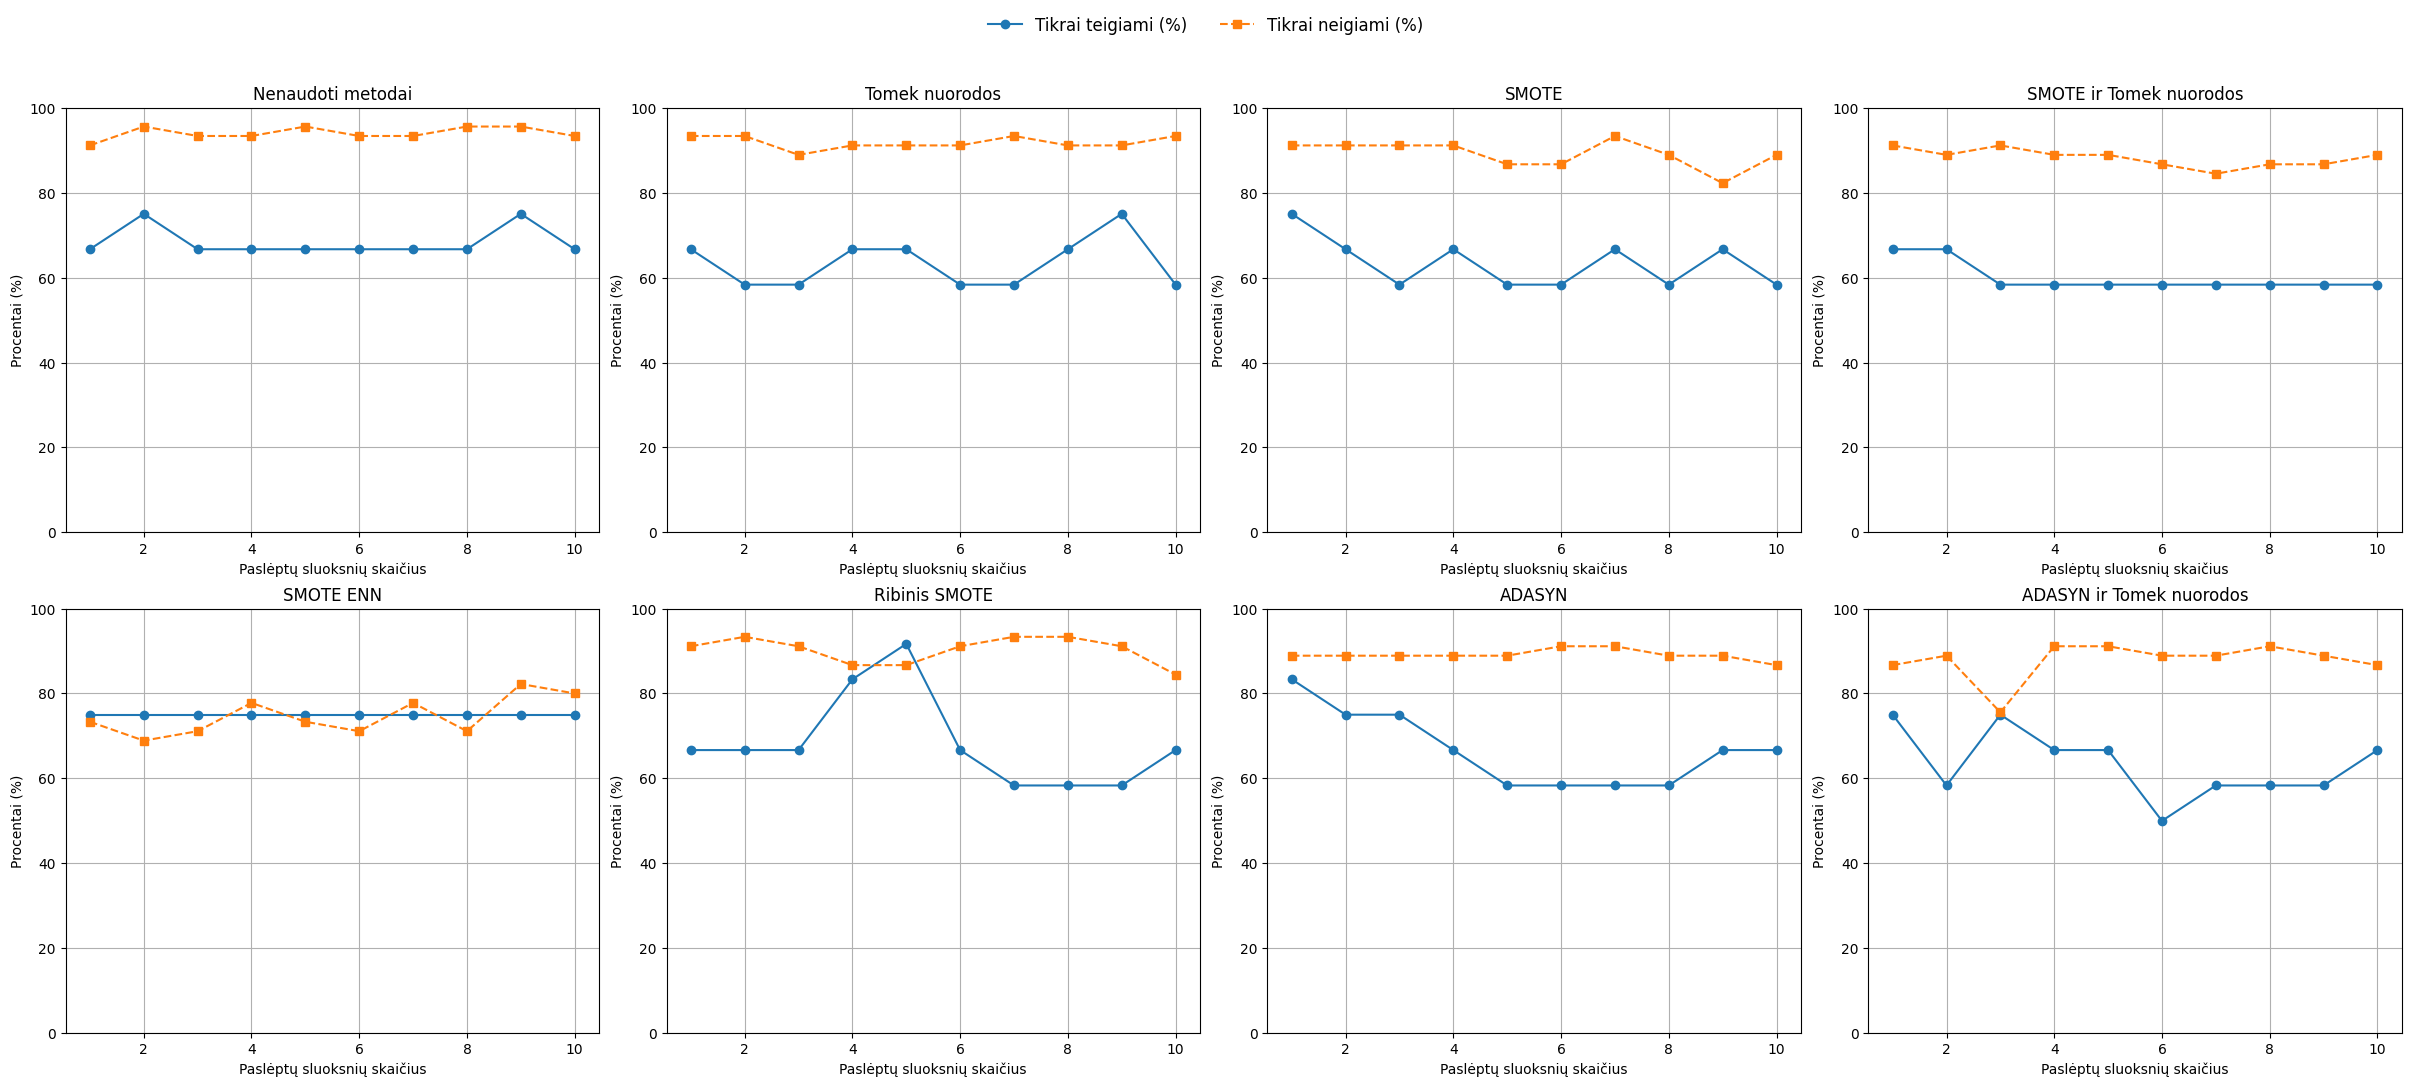

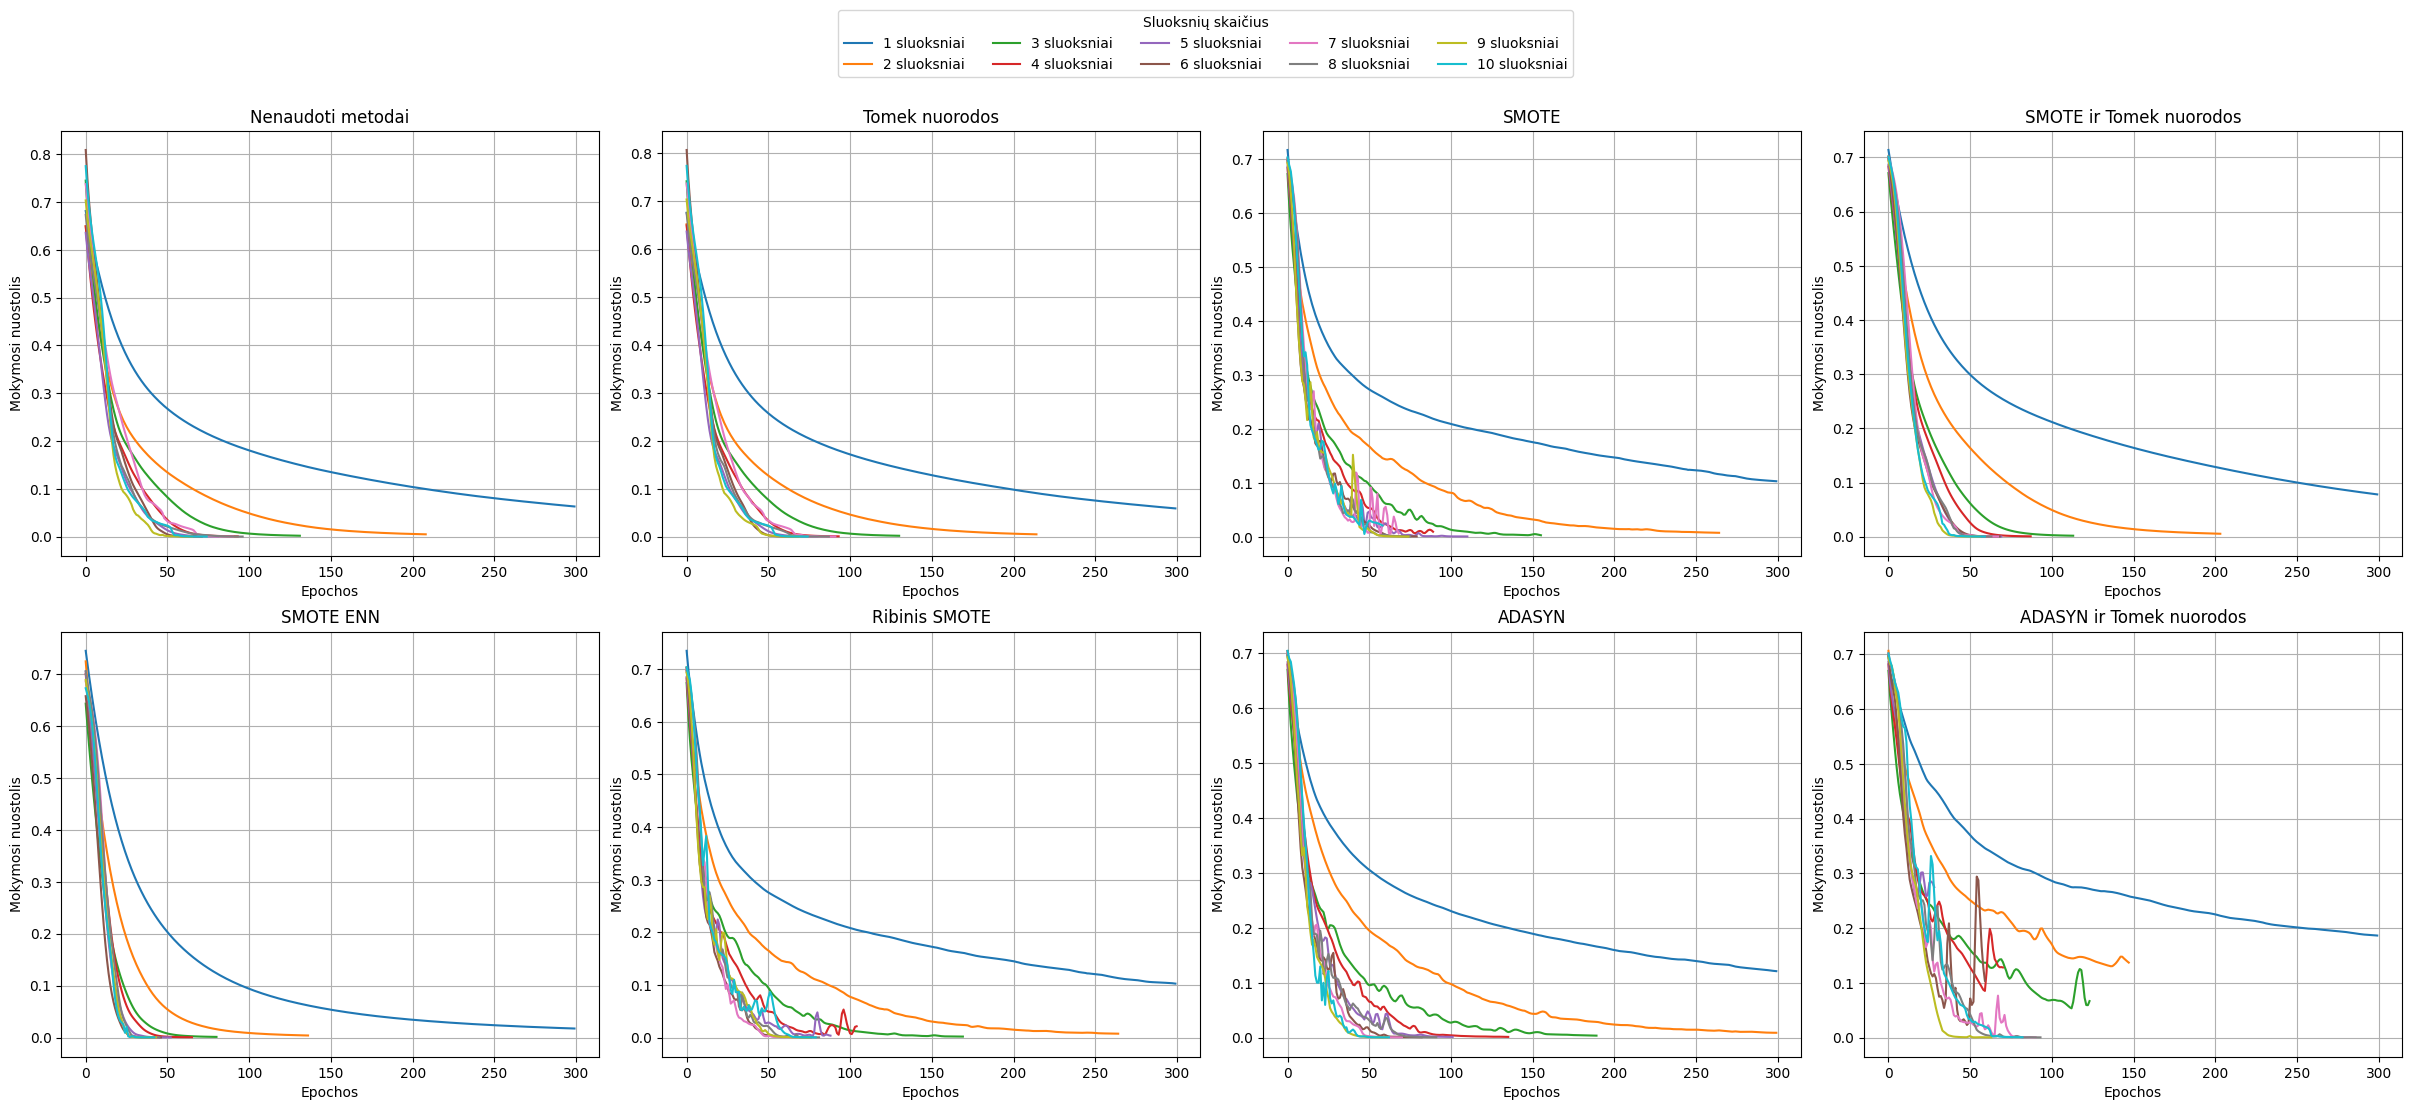

In [11]:
# MLP klasifikavimo rezultatai keičiant paslėptų sluoksnių skaičių
# Mokymosi nuostolių analizė pagal MLP gylį naudojant po 100 neuronų sluoksnyje
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

df = pd.read_csv('dataset_heart_reduced.csv', encoding='utf-8-sig')
X = df.drop(columns=['Širdies liga'])
y = df['Širdies liga']

Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=900
)

scaler0  = StandardScaler().fit(Xb_tr)
Xb_tr_s  = scaler0.transform(Xb_tr)
Xb_te_s  = scaler0.transform(Xb_te)

mlp0 = MLPClassifier(
    hidden_layer_sizes=(100,),
    max_iter=500,
    random_state=1
)
mlp0.fit(Xb_tr_s, yb_tr)

cm0 = confusion_matrix(yb_te, mlp0.predict(Xb_te_s))
pct0 = cm0.astype(float)/cm0.sum(axis=1)[:,None]*100
baseline_tp = pct0[1,1]
baseline_tn = pct0[0,0]
print(f"Baseline TP%={baseline_tp:.2f}, TN%={baseline_tn:.2f}")


adasyn_tomek = ImbPipeline([
    ('adasyn',   ADASYN(sampling_strategy=0.99, random_state=7)),
    ('tomek',    TomekLinks())
])

methods = [
    (None,                       "Nenaudoti metodai"),
    (TomekLinks(),               "Tomek nuorodos"),
    (SMOTE(sampling_strategy=0.99, random_state=7),      "SMOTE"),
    (SMOTETomek(sampling_strategy=0.99, random_state=7), "SMOTE ir Tomek nuorodos"),
    (SMOTEENN(sampling_strategy=0.99, random_state=7),    "SMOTE ENN"),
    (BorderlineSMOTE(sampling_strategy=0.99, random_state=7),"Ribinis SMOTE"),
    (ADASYN(sampling_strategy=0.99, random_state=7),     "ADASYN"),
    (adasyn_tomek,               "ADASYN ir Tomek nuorodos"),
]


scaler = StandardScaler()

def train_and_eval(Xtr, ytr, Xte, yte, L):
    mlp = MLPClassifier(
        hidden_layer_sizes=(100,)*L,
        max_iter=300,
        random_state=7
    )
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)
    mlp.fit(Xtr_s, ytr)
    cm = confusion_matrix(yte, mlp.predict(Xte_s))
    pct= cm.astype(float)/cm.sum(axis=1)[:,None]*100
    return pct[1,1], pct[0,0], mlp.loss_curve_


layer_range = range(1,11)
tp_res    = {title: [] for _,title in methods}
tn_res    = {title: [] for _,title in methods}
loss_res  = {title: [] for _,title in methods}

for sampler, title in methods:
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.3,
        stratify=y, random_state=7
    )
    if sampler is None:
        Xr, yr = Xtr, ytr
    elif isinstance(sampler, tuple):
        Xr, yr = sampler[0].fit_resample(Xtr,ytr)
        Xr, yr = sampler[1].fit_resample(Xr,yr)
    else:
        Xr, yr = sampler.fit_resample(Xtr,ytr)

    for L in layer_range:
        tp, tn, lc = train_and_eval(Xr,yr,Xte,yte, L)
        tp_res[title].append(tp)
        tn_res[title].append(tn)
        loss_res[title].append(lc)

tp_res["Nenaudoti metodai"][0] = baseline_tp
tn_res["Nenaudoti metodai"][0] = baseline_tn


fig, axes = plt.subplots(2,4, figsize=(24,10), constrained_layout=True)
axes = axes.flatten()

for ax,( _,title) in zip(axes, methods):
    ax.plot(layer_range, tp_res[title], marker='o', label='TP%')
    ax.plot(layer_range, tn_res[title], marker='s', label='TN%', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Paslėptų sluoksnių skaičius')
    ax.set_ylabel('Procentai (%)')
    ax.set_ylim(0,100)
    ax.grid(True)

fig.legend(['Tikrai teigiami (%)', 'Tikrai neigiami (%)'],
           loc='upper center',
           bbox_to_anchor=(0.5, 1.08), 
           ncol=5,
           fontsize=12,
           frameon=False) 

# plt.savefig("hear_layers_100_all.png", dpi=300, bbox_inches='tight')

plt.show()


fig2, axes2 = plt.subplots(2, 4, figsize=(24,10), constrained_layout=True)
axes2 = axes2.flatten()

for ax, (_, title) in zip(axes2, methods):
    for L, lc in zip(layer_range, loss_res[title]):
        ax.plot(lc, label=f'{L} sluoksniai')
    ax.set_title(title)
    ax.set_xlabel('Epochos')
    ax.set_ylabel('Mokymosi nuostolis')
    ax.grid(True)


handles, labels = axes2[-1].get_legend_handles_labels()
fig2.legend(
    handles, labels,
    loc='lower center',     
    bbox_to_anchor=(0.5, 1.02),  
    ncol=5,
    title='Sluoksnių skaičius'
)

# plt.savefig("heart_epoch_100_all.png", dpi=300, bbox_inches='tight')
plt.show()


/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Baseline TP%=66.67, TN%=93.33


/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691:

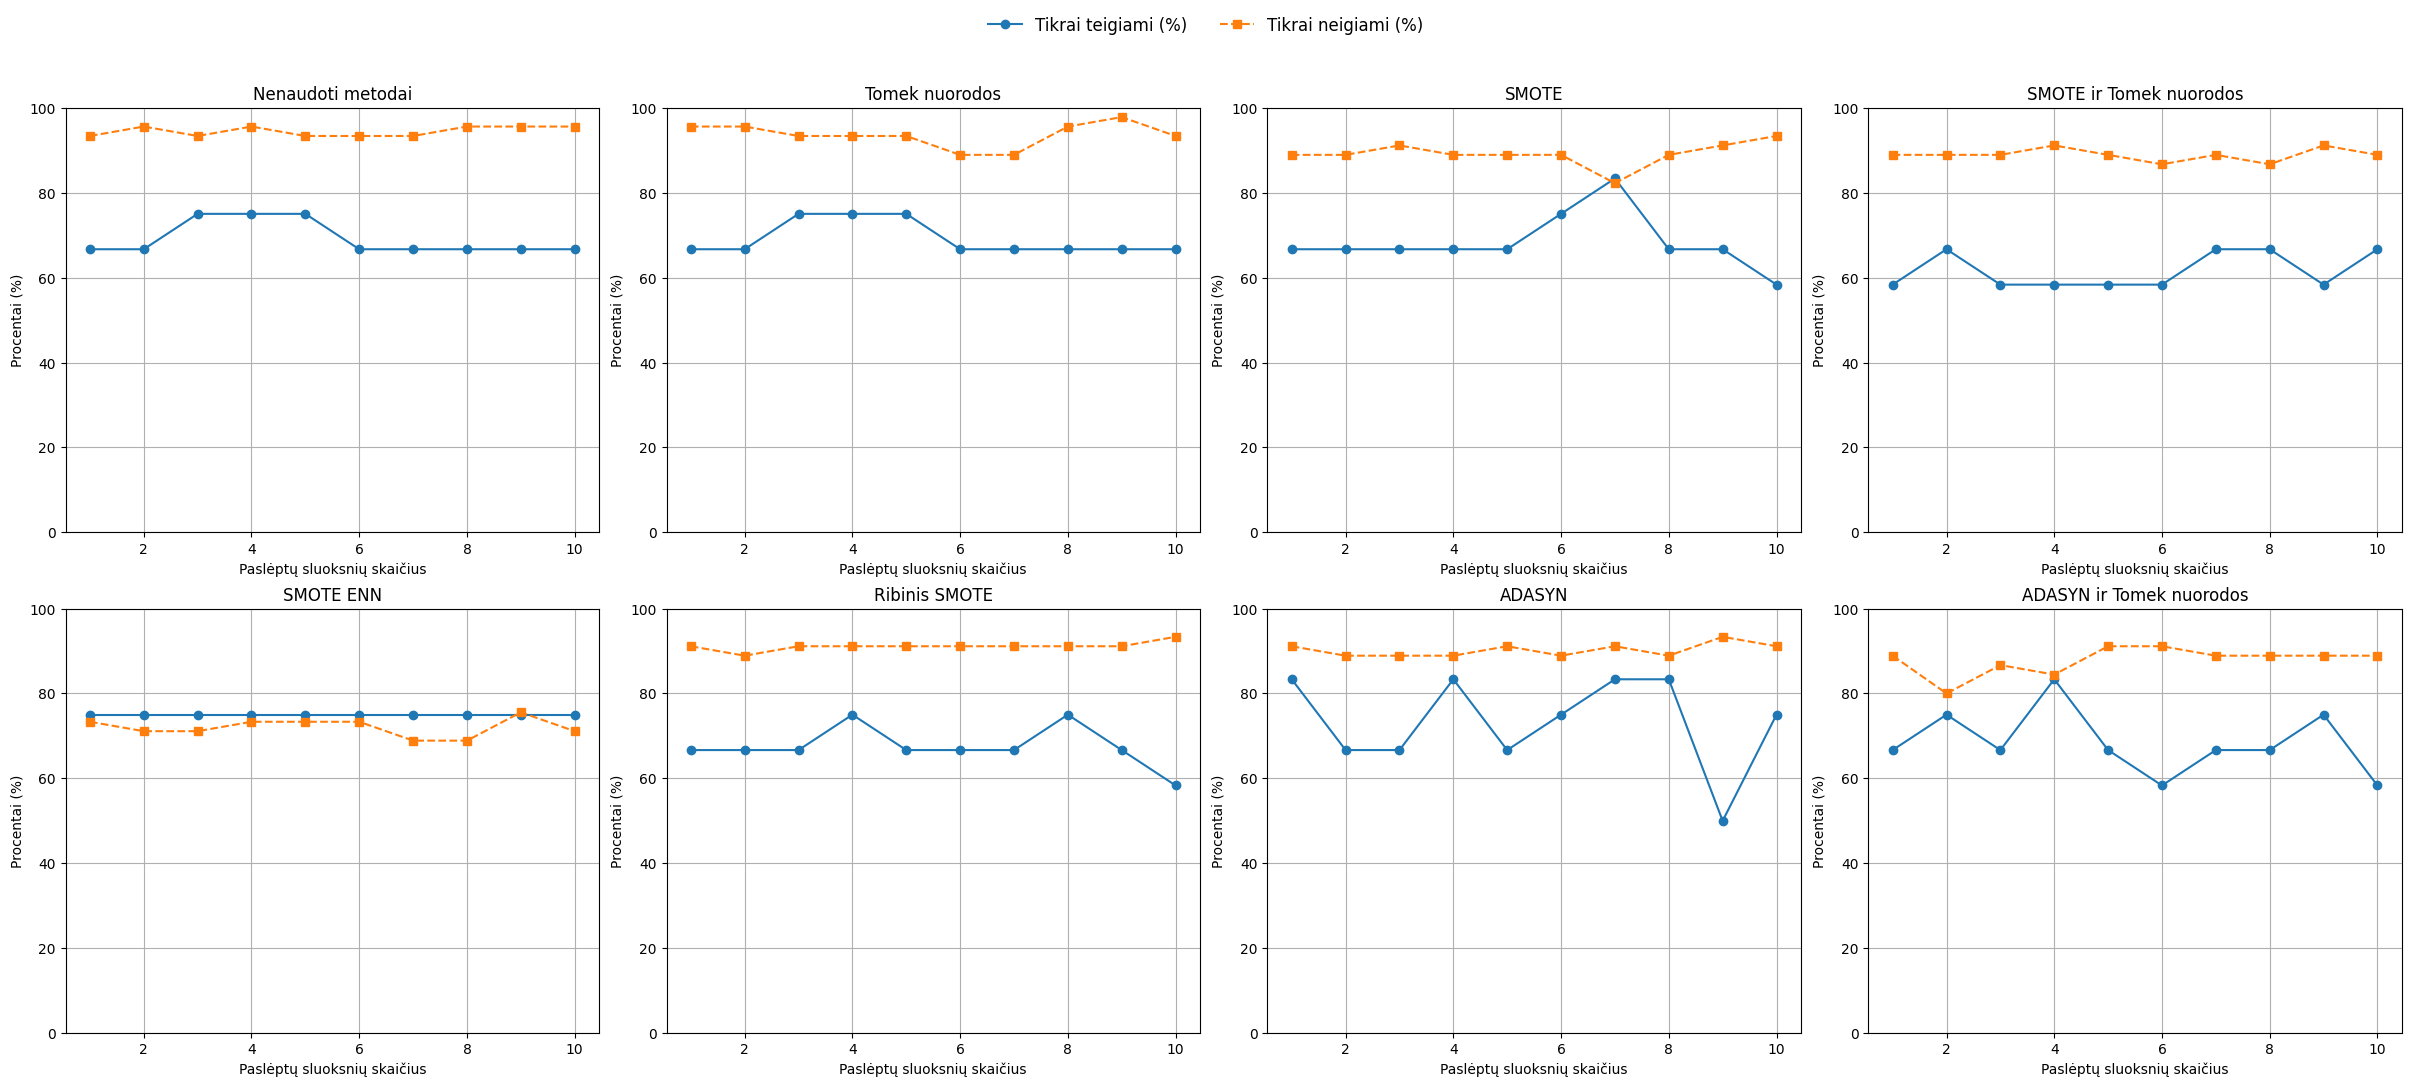

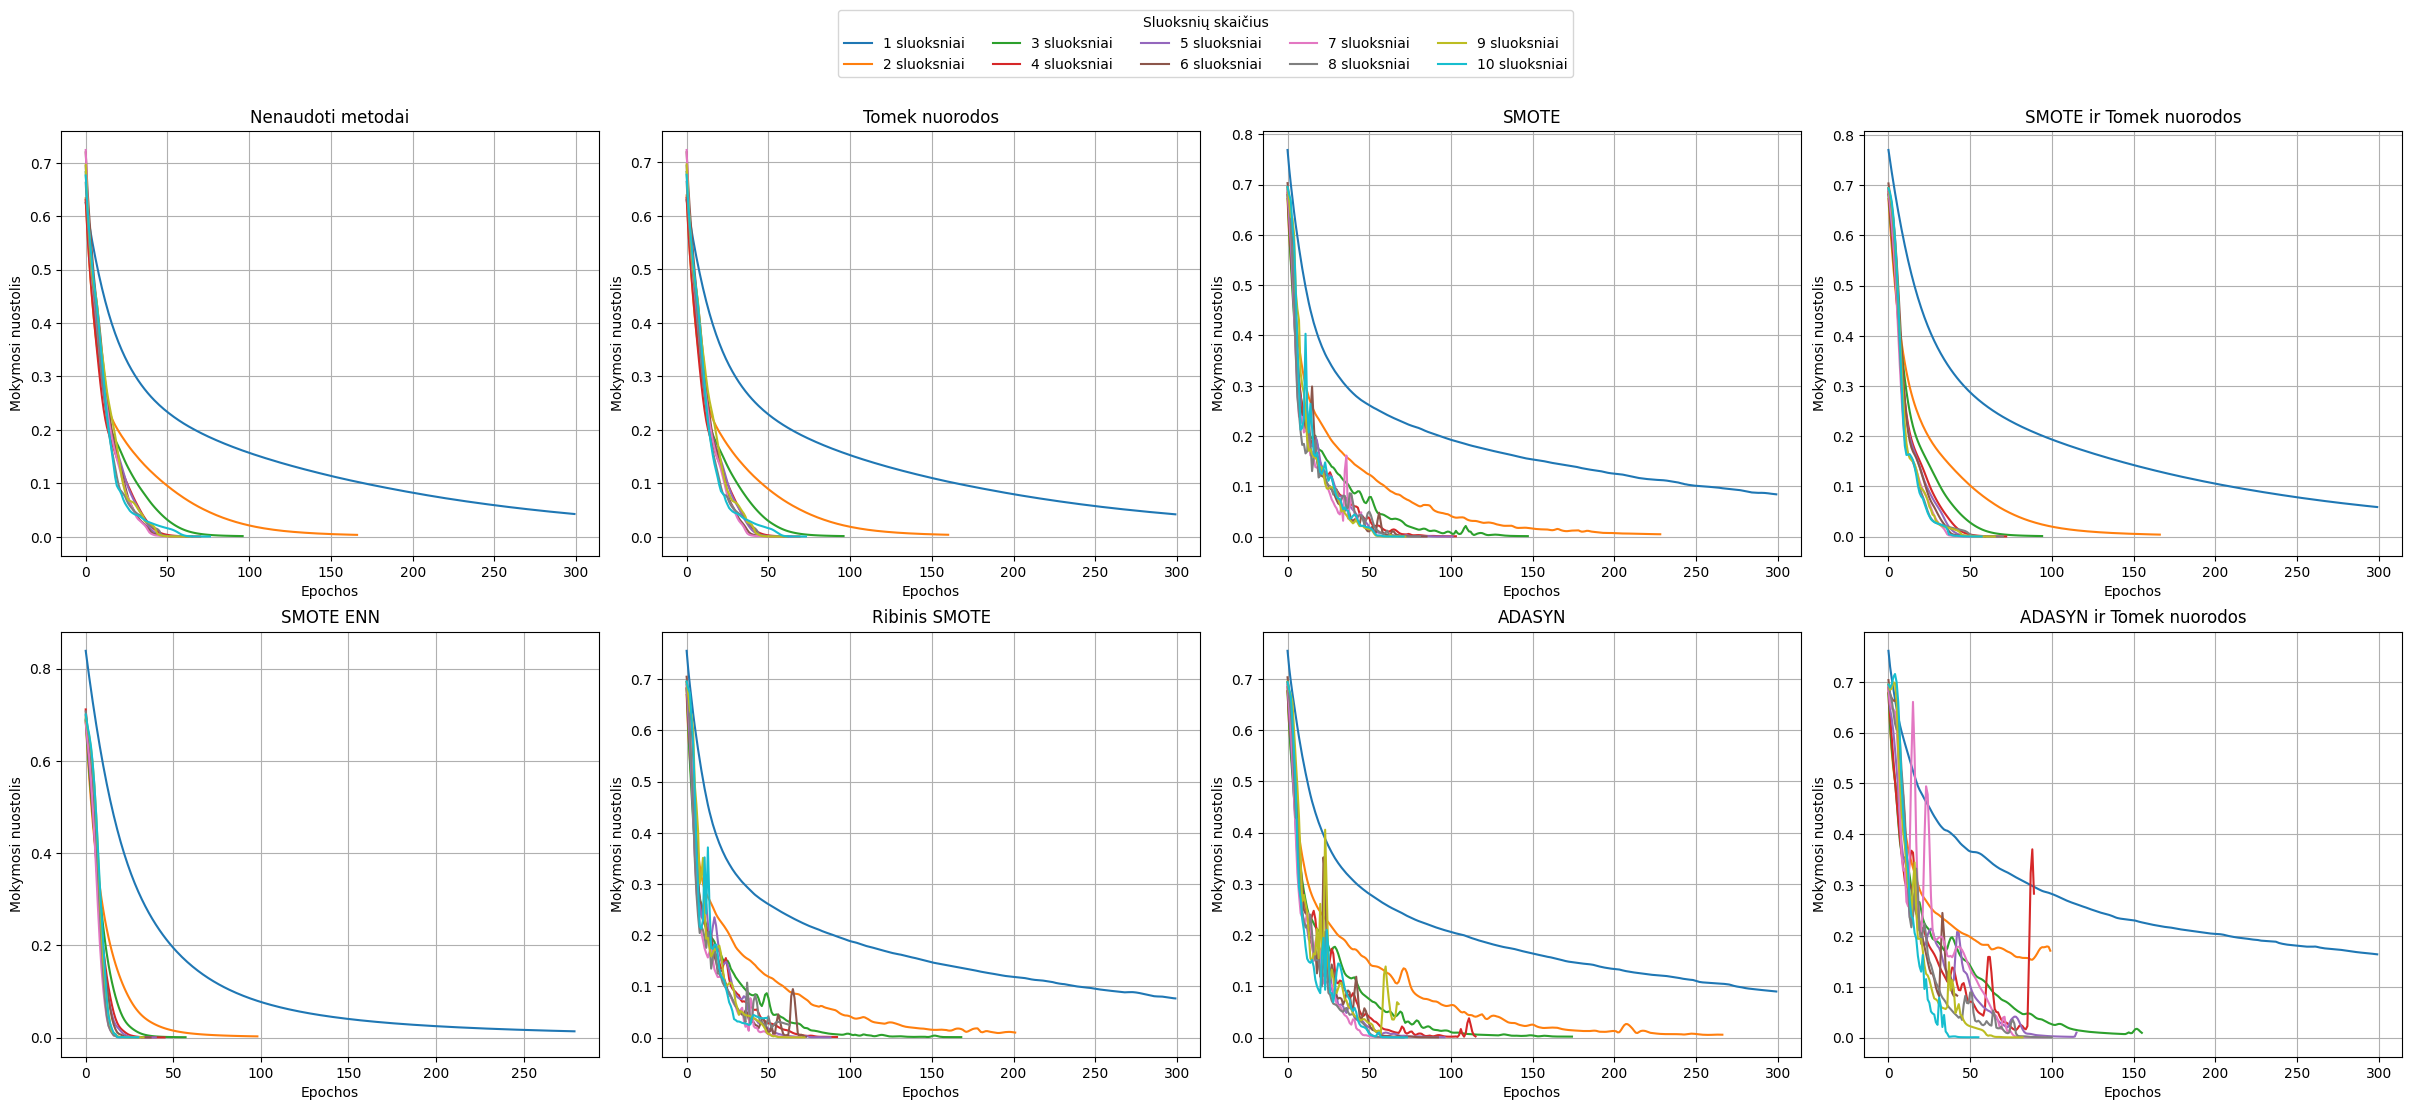

In [12]:
# MLP klasifikavimo rezultatai keičiant paslėptų sluoksnių skaičių
# Mokymosi nuostolių analizė pagal MLP gylį naudojant po 150 neuronų sluoksnyje
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

df = pd.read_csv('dataset_heart_reduced.csv', encoding='utf-8-sig')
X = df.drop(columns=['Širdies liga'])
y = df['Širdies liga']

Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=900
)

scaler0  = StandardScaler().fit(Xb_tr)
Xb_tr_s  = scaler0.transform(Xb_tr)
Xb_te_s  = scaler0.transform(Xb_te)

mlp0 = MLPClassifier(
    hidden_layer_sizes=(50,),
    max_iter=500,
    random_state=1
)
mlp0.fit(Xb_tr_s, yb_tr)

cm0 = confusion_matrix(yb_te, mlp0.predict(Xb_te_s))
pct0 = cm0.astype(float)/cm0.sum(axis=1)[:,None]*100
baseline_tp = pct0[1,1]
baseline_tn = pct0[0,0]
print(f"Baseline TP%={baseline_tp:.2f}, TN%={baseline_tn:.2f}")


adasyn_tomek = ImbPipeline([
    ('adasyn',   ADASYN(sampling_strategy=0.99, random_state=7)),
    ('tomek',    TomekLinks())
])

methods = [
    (None,                       "Nenaudoti metodai"),
    (TomekLinks(),               "Tomek nuorodos"),
    (SMOTE(sampling_strategy=0.99, random_state=7),      "SMOTE"),
    (SMOTETomek(sampling_strategy=0.99, random_state=7), "SMOTE ir Tomek nuorodos"),
    (SMOTEENN(sampling_strategy=0.99, random_state=7),    "SMOTE ENN"),
    (BorderlineSMOTE(sampling_strategy=0.99, random_state=7),"Ribinis SMOTE"),
    (ADASYN(sampling_strategy=0.99, random_state=7),     "ADASYN"),
    (adasyn_tomek,               "ADASYN ir Tomek nuorodos"),
]


scaler = StandardScaler()

def train_and_eval(Xtr, ytr, Xte, yte, L):
    mlp = MLPClassifier(
        hidden_layer_sizes=(150,)*L,
        max_iter=300,
        random_state=7
    )
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)
    mlp.fit(Xtr_s, ytr)
    cm = confusion_matrix(yte, mlp.predict(Xte_s))
    pct= cm.astype(float)/cm.sum(axis=1)[:,None]*100
    return pct[1,1], pct[0,0], mlp.loss_curve_

layer_range = range(1,11)
tp_res    = {title: [] for _,title in methods}
tn_res    = {title: [] for _,title in methods}
loss_res  = {title: [] for _,title in methods}

for sampler, title in methods:
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.3,
        stratify=y, random_state=7
    )
    if sampler is None:
        Xr, yr = Xtr, ytr
    elif isinstance(sampler, tuple):
        Xr, yr = sampler[0].fit_resample(Xtr,ytr)
        Xr, yr = sampler[1].fit_resample(Xr,yr)
    else:
        Xr, yr = sampler.fit_resample(Xtr,ytr)

    for L in layer_range:
        tp, tn, lc = train_and_eval(Xr,yr,Xte,yte, L)
        tp_res[title].append(tp)
        tn_res[title].append(tn)
        loss_res[title].append(lc)

tp_res["Nenaudoti metodai"][0] = baseline_tp
tn_res["Nenaudoti metodai"][0] = baseline_tn

fig, axes = plt.subplots(2,4, figsize=(24,10), constrained_layout=True)
axes = axes.flatten()

for ax,( _,title) in zip(axes, methods):
    ax.plot(layer_range, tp_res[title], marker='o', label='TP%')
    ax.plot(layer_range, tn_res[title], marker='s', label='TN%', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Paslėptų sluoksnių skaičius')
    ax.set_ylabel('Procentai (%)')
    ax.set_ylim(0,100)
    ax.grid(True)

fig.legend(['Tikrai teigiami (%)', 'Tikrai neigiami (%)'],
           loc='upper center',
           bbox_to_anchor=(0.5, 1.08), 
           ncol=5,
           fontsize=12,
           frameon=False) 
# plt.savefig("hear_layers_150_all.png", dpi=300, bbox_inches='tight')

plt.show()

fig2, axes2 = plt.subplots(2, 4, figsize=(24,10), constrained_layout=True)
axes2 = axes2.flatten()

for ax, (_, title) in zip(axes2, methods):
    for L, lc in zip(layer_range, loss_res[title]):
        ax.plot(lc, label=f'{L} sluoksniai')
    ax.set_title(title)
    ax.set_xlabel('Epochos')
    ax.set_ylabel('Mokymosi nuostolis')
    ax.grid(True)

handles, labels = axes2[-1].get_legend_handles_labels()
fig2.legend(
    handles, labels,
    loc='lower center',     
    bbox_to_anchor=(0.5, 1.02),  
    ncol=5,
    title='Sluoksnių skaičius'
)

# plt.savefig("heart_epoch_150_all.png", dpi=300, bbox_inches='tight')
plt.show()
